In [25]:
import os
import argparse
from typing import List
from datetime import datetime
import data
import network
import solver
import joblib
import json
import torch

import matplotlib.pyplot as plt
import numpy as np

In [29]:
from dataclasses import dataclass
from typing import List
@dataclass
class TransientRLTask(data.base.BaseDataLoader):
    """Transient task data modules.

    Datapoints are sampled from unit nomral gaussian in batch, size of [batch_size, input_dim]

    Args:
        seq_len_list: a list of length of input sequence from different gaussian distribution.
        batch_size: batch size. 
        input_dim: size of dimension where continuous value is used. 
        
    """
    seq_len: List[int]
    batch_size: int
    input_dim: int
    identical: bool

    def __post_init__(self):

        self.mean = torch.tensor([0.])
        self.variance = torch.tensor([1])
        self.dist = torch.distributions.Normal(loc=self.mean,
                                               scale=torch.sqrt(self.variance))

    def get_batch(self):
        if not self.identical:
            return {
                'x': [
                    self.dist.sample(
                        (self.batch_size, l, self.input_dim)).squeeze(dim=-1)
                    for _, l in enumerate(self.seq_len)
                ]
            }
        else:
            x = self.dist.sample(
                        (self.batch_size, self.seq_len[0], self.input_dim)).squeeze(dim=-1)
            return {
                'x': [ x for _ in self.seq_len]}
                    
    def __str__(self):
        return f"TransientRLTask(seq_len:{self.seq_len}, batch_size:{self.batch_size}, input_dim:{self.input_dim})"


In [30]:
def initialize_nets(input_dim: int, num_tasks: int):
    teachers = []
    students = []
    for i in range(num_tasks):
        teacher = network.ContinuousTeacher(input_dimension=input_dim,
                                            hidden_dimensions=[1],
                                            nonlinearity='sign',
                                            standardize=True,
                                            normalize=True)
        student = network.ContinuousStudent(input_dimension=input_dim,
                                            hidden_dimensions=[1],
                                            nonlinearity='sign',
                                            initialisation_std = 0.001,
                                            normalize=True)
        teachers.append(teacher)
        students.append(student)

    teacher_c = network.ContextTeacher(input_dimension=num_tasks,
                                       hidden_dimensions=[1],
                                       weights = [1.],
                                       nonlinearity='sign',
                                       normalize=False)
    student_c = network.ContextStudent(input_dimension=num_tasks,
                                       hidden_dimensions=[1],
                                       nonlinearity='sign',
                                       initialisation_std = 0.001,
                                       normalize=False)

    return teachers, students, teacher_c, student_c

In [66]:
input_dim= 1000
num_tasks = 4
seq_length=4
lr_ws= [10,1]
lr_v = 0.1
nums_iter = [0,400000]
update_frequency= 1000 
seeds=1
identical= False

In [67]:
for seed in range(seeds):

        teachers, students, context_teacher, context_student = initialize_nets(
            input_dim, num_tasks)
        VS = context_student.layers[0].weight.data.numpy()[0]
        VT = context_teacher.layers[0].weight.data.numpy()[0]
        if identical:
            ode_solver1_niid = solver.HierarchicalODESolverIdentical(VS=VS,
                                                    VT=VT,
                                                    students=students,
                                                    teachers=teachers,
                                                    lr_ws=lr_ws,
                                                    lr_v=lr_v,
                                                    seq_length=seq_length,
                                                    N=input_dim)
        else:
            ode_solver1_niid = solver.HierarchicalODESolver(VS=VS,
                                                    VT=VT,
                                                    students=students,
                                                    teachers=teachers,
                                                    lr_ws=lr_ws,
                                                    lr_v=lr_v,
                                                    seq_length=seq_length,
                                                    N=input_dim)

        ode_solver1_niid.train(nums_iter=nums_iter, update_frequency=update_frequency)

dataloader = TransientRLTask(batch_size = 1, seq_len = [seq_length, seq_length, seq_length,seq_length], input_dim = input_dim, identical = identical)
simulator1_niid = solver.TwoPhaseContextSolver(teachers=teachers, students = students, context_teacher=context_teacher, context_student=context_student, dataloaders = [dataloader, dataloader, dataloader], logdir = None, identical=identical)
simulator1_niid.train(nums_iter = nums_iter, lrs = [(lr_ws[0], 0),(lr_ws[1], lr_v)], update_frequency=update_frequency)

In [68]:
def viz_each_seed(simulator, ode_solver, phase):
    _ode=False
    _simul=False

    def _get_data(result):
        Qmat=result[f'phase{phase}']['Q']
        Rmat=result[f'phase{phase}']['R']
        Pmat=result[f'phase{phase}']['P']
        Vmat=result[f'phase{phase}']['P']
        P_tildemat = result[f'phase{phase}']['P_tilde']

        QS = [[k[n][n] for k in Qmat] for n in range(4)]
        RS = [[k[n][n] for k in Rmat] for n in range(4)]
        PS = [[k[n] for k in Pmat]for n in range(4)]
        VS = [[k[n] for k in Vmat]for n in range(4)]
        
        return QS, RS, PS, VS, P_tildemat


    if simulator is not None:
        _simul = True
    if ode_solver is not None:
        _ode = True
    
    if _ode or _simul:
        fig = plt.figure(figsize=(20,4))
        
        ax1 = plt.subplot(141)
        ax2 = plt.subplot(142)
        ax3 = plt.subplot(143)
        ax4 = plt.subplot(144)
        cs=['r','g', 'b', 'y', 'cyan']
        if _ode:
            result = ode_solver.history
            QS, RS, PS, VS, P_tildemat = _get_data(result)
            for i in range(len(QS)):
                c=cs[i]
                ode_line, =ax1.plot(QS[i], label = 'ode', c = c, alpha = 0.5)
                ax2.plot(RS[i], label = 'ode', c = c, alpha = 0.5)
                ax3.plot(np.power(PS[i],4), label = 'ode', c = c, alpha = 0.5)
            ax4.plot(np.power(P_tildemat,4), label = 'ode', c= 'gray', alpha=0.5)
            
            ax1.set_title(f'Q')
            ax2.set_title(f'R')
            ax3.set_title(f'P')
            ax4.set_title(f'P_tilde')
                
                
        if _simul:
            result = simulator.history
            QS, RS, PS, VS, P_tildemat = _get_data(result)
            for i in range(len(QS)):
                c=cs[i]
                sim_line, =ax1.plot(QS[i], label = 'sim', c = c, alpha = 0.5,ls = '--')
                ax2.plot(RS[i], label = 'sim', c = c, alpha = 0.5, ls = '--')
                ax3.plot(np.power(PS[i],4), label = 'sim', c = c, alpha = 0.5, ls = '--')
            ax4.plot(np.power(P_tildemat,4), label = 'sim', c= 'gray', alpha=0.5, ls = '--')
            
            ax1.set_title(f'Q')
            ax2.set_title(f'R')
            ax3.set_title(f'P')
            ax4.set_title(f'P_tilde')
        
        handles = []
        
        if _ode :
            handles.append(ode_line)
        if _simul :
            handles.append(sim_line)
                      
        ax1.legend(handles=handles)
        
            

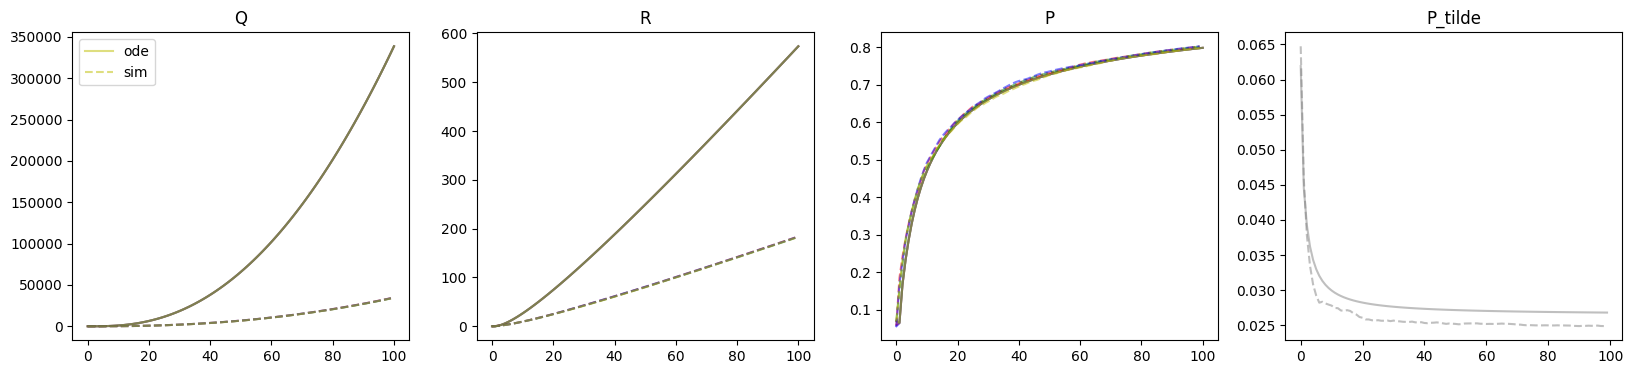

In [28]:
viz_each_seed(simulator, ode_solver)

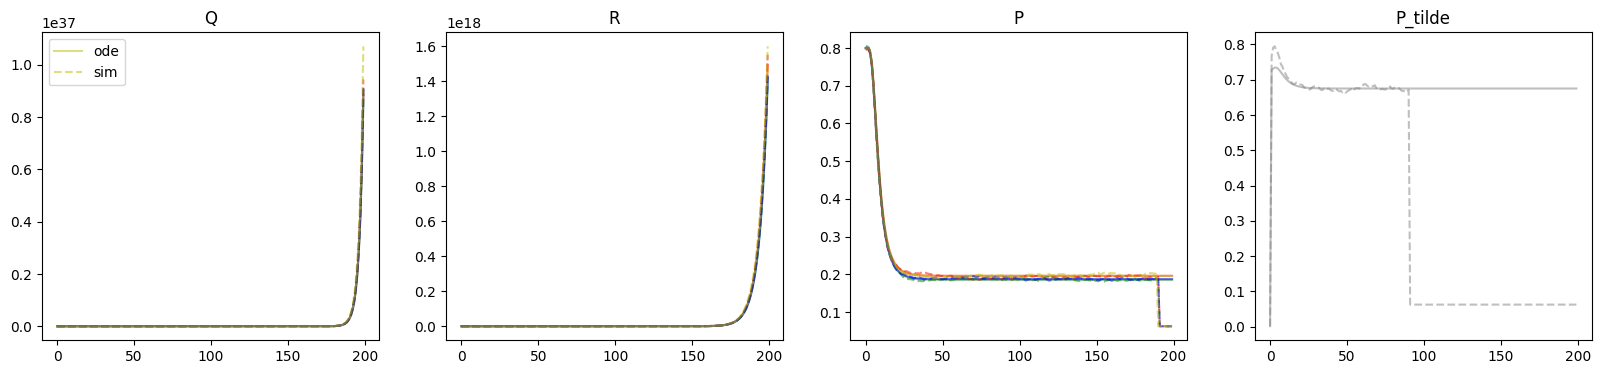

In [41]:
viz_each_seed(simulator1, ode_solver1, 2)

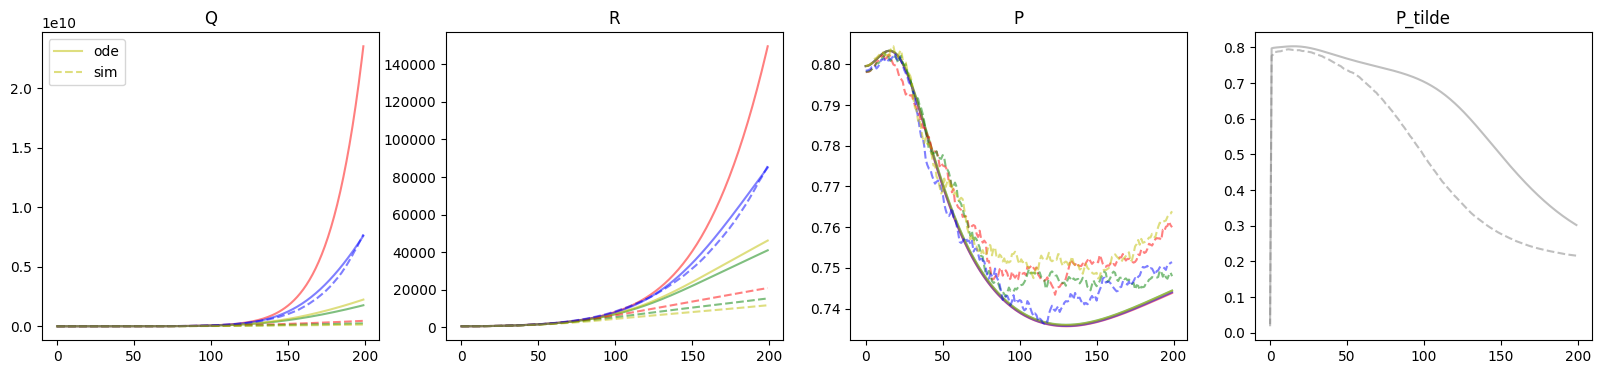

In [51]:
viz_each_seed(simulator1_niid, ode_solver1_niid, 2)

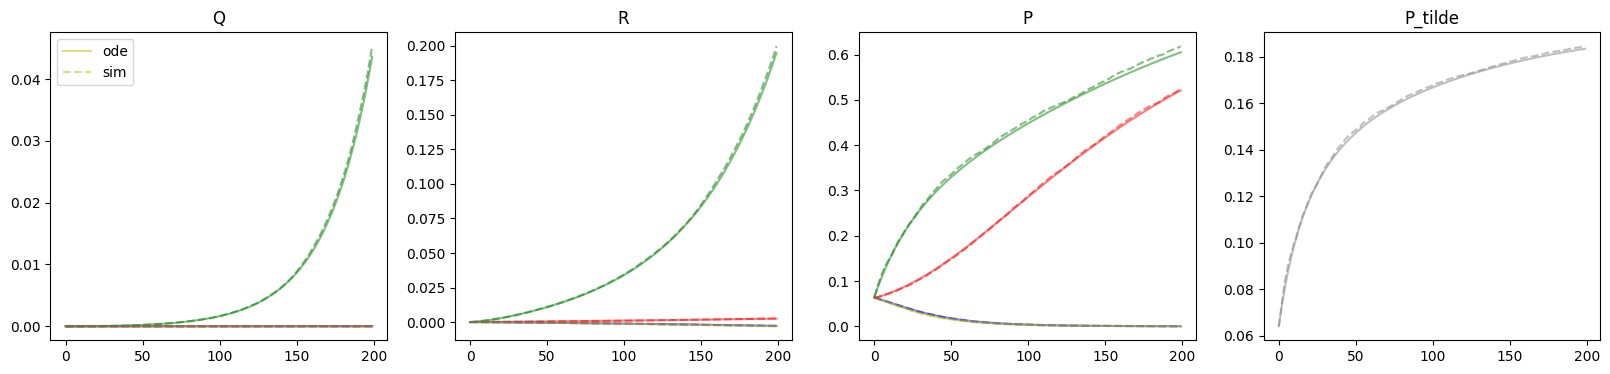

In [61]:
viz_each_seed(simulator1_niid, ode_solver1_niid, 2)

In [56]:
simulator1_niid.history['phase1']['R'][0]

array([[-9.13367330e-07, -3.76542957e-05, -5.61067282e-06,
        -3.50188566e-06],
       [-3.80210913e-05, -5.52861547e-06,  1.56940223e-05,
        -2.30221176e-05],
       [ 6.23972373e-05,  1.40584925e-05,  9.17154557e-06,
        -4.28027197e-05],
       [ 5.47699783e-05,  9.05278212e-05, -1.01109516e-04,
        -4.96132998e-05]])

In [55]:
ode_solver1_niid.history['phase1']['R'][0]

array([[-9.13371332e-07, -3.76542956e-05, -5.61068207e-06,
        -3.50188278e-06],
       [-3.80210876e-05, -5.52861532e-06,  1.56940185e-05,
        -2.30221301e-05],
       [ 6.23972341e-05,  1.40584884e-05,  9.17154737e-06,
        -4.28027287e-05],
       [ 5.47699630e-05,  9.05278176e-05, -1.01109505e-04,
        -4.96133044e-05]])

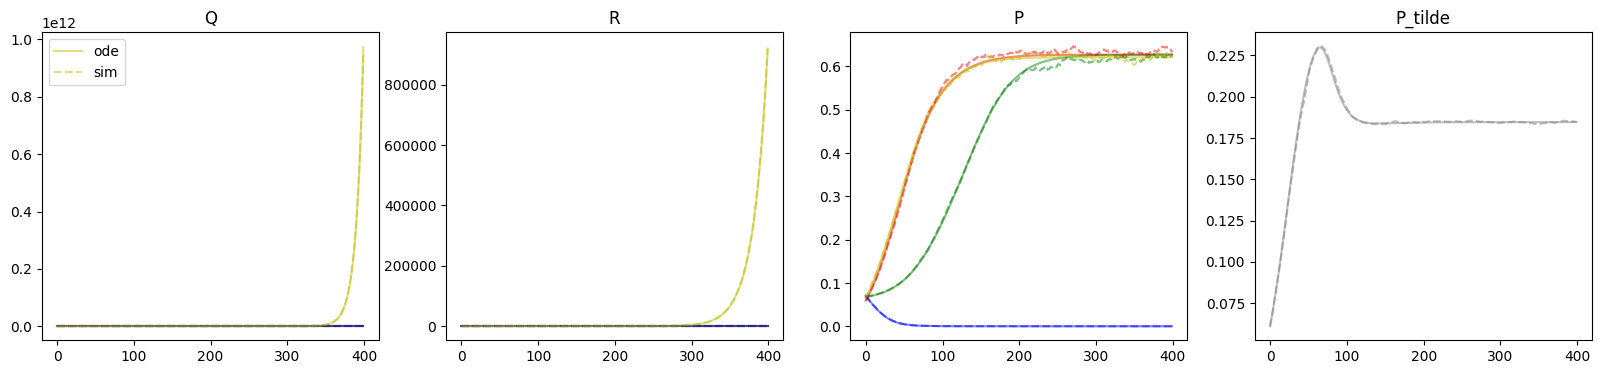

In [70]:
viz_each_seed(simulator1_niid, ode_solver1_niid, 2)